# Dot Plot of Neuromodulator Receptor Expression in the Basolateral Amygdala (MERFISH)

This notebook uses **MERFISH spatial transcriptomics** data from the Allen Brain Cell
(ABC) Atlas to visualize neuromodulator receptor expression across cell types in the
**basolateral amygdala (BLA)** of the mouse brain.

### Key Advantage over 10x Data
Unlike the 10x snRNA-seq data (which only has coarse dissection regions like CTXsp),
MERFISH cells are registered to the **Allen Common Coordinate Framework (CCF)**, providing
fine parcellation down to BLA substructures (BLAa, BLAp, BLAv). This means:
- **All cell types are BLA-localized**, including interneurons
- No need for the hybrid approach used in the 10x notebook
- Glia (astrocytes, microglia) are also BLA-specific

### MERFISH Gene Panel Limitation
The MERFISH panel contains 550 genes — a targeted subset of the transcriptome.
Of the 28 neuromodulator receptor genes analyzed in the 10x notebooks, **11 are
available** in the MERFISH panel:
- **Serotonin (5)**: Htr1b, Htr1d, Htr2a, Htr3a, Htr7
- **Norepinephrine (2)**: Adra1a, Adra1b
- **Dopamine (4)**: Drd1, Drd2, Drd3, Drd5

### Prerequisites
- Internet connection (for downloading data from AWS S3)
- Packages: `abc_atlas_access`, `anndata`, `scanpy`, `pandas`, `numpy`, `matplotlib`

In [1]:
import pandas as pd
import numpy as np
import re
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
from pathlib import Path

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

## 1. Initialize the ABC Atlas Cache

In [2]:
download_base = Path('../../data/abc_atlas')
abc_cache = AbcProjectCache.from_s3_cache(download_base)

print(f"Current manifest: {abc_cache.current_manifest}")

Current manifest: releases/20251031/manifest.json


## 2. Load Cell Metadata with CCF Parcellation

The MERFISH-CCF dataset provides cell metadata already joined with both
the WMB taxonomy (subclass, supertype, etc.) and CCF spatial parcellation
(parcellation_structure = BLA, parcellation_substructure = BLAa/BLAp/BLAv).

In [3]:
# Load MERFISH cell metadata with CCF parcellation annotations
ccf_meta = abc_cache.get_metadata_dataframe(
    directory='MERFISH-C57BL6J-638850-CCF',
    file_name='cell_metadata_with_parcellation_annotation',
    dtype={'cell_label': str}
)
ccf_meta.set_index('cell_label', inplace=True)
print(f"Total MERFISH cells with CCF: {len(ccf_meta):,}")

Total MERFISH cells with CCF: 3,739,961


## 3. Identify BLA Cells

Filter to cells within the **basolateral amygdala (BLA)** using CCF parcellation.
This includes all three BLA substructures: BLAa (anterior), BLAp (posterior),
and BLAv (ventral).

In [4]:
# Filter to BLA by CCF parcellation
bla_cells = ccf_meta[ccf_meta['parcellation_structure'] == 'BLA'].copy()
print(f"BLA cells: {len(bla_cells):,}")

print(f"\nBLA substructures:")
for sub, count in bla_cells.groupby('parcellation_substructure', observed=True).size().items():
    print(f"  {sub}: {count:,} cells")

print(f"\nAll BLA subclasses:")
for sc_name, count in bla_cells.groupby('subclass', observed=True).size().sort_values(ascending=False).items():
    print(f"  {sc_name}: {count:,} cells")

BLA cells: 13,233

BLA substructures:
  BLAa: 5,933 cells
  BLAp: 4,647 cells
  BLAv: 2,653 cells

All BLA subclasses:
  014 LA-BLA-BMA-PA Glut: 4,484 cells
  319 Astro-TE NN: 1,832 cells
  333 Endo NN: 973 cells
  013 COAp Grxcr2 Glut: 595 cells
  327 Oligo NN: 531 cells
  064 STR-PAL Chst9 Gaba: 495 cells
  009 L2/3 IT PIR-ENTl Glut: 421 cells
  326 OPC NN: 413 cells
  003 L5/6 IT TPE-ENT Glut: 404 cells
  053 Sst Gaba: 369 cells
  052 Pvalb Gaba: 322 cells
  113 MEA-COA-BMA Ccdc42 Glut: 321 cells
  046 Vip Gaba: 280 cells
  334 Microglia NN: 265 cells
  331 Peri NN: 206 cells
  047 Sncg Gaba: 144 cells
  049 Lamp5 Gaba: 137 cells
  114 COAa-PAA-MEA Barhl2 Glut: 133 cells
  012 MEA Slc17a7 Glut: 125 cells
  054 STR Prox1 Lhx6 Gaba: 121 cells
  051 Pvalb chandelier Gaba: 84 cells
  080 CEA-AAA-BST Six3 Sp9 Gaba: 69 cells
  332 SMC NN: 46 cells
  050 Lamp5 Lhx6 Gaba: 45 cells
  016 CA1-ProS Glut: 45 cells
  318 Astro-NT NN: 37 cells
  048 RHP-COA Ndnf Gaba: 34 cells
  002 IT EP-CLA Glu

In [5]:
# Select neuronal + glial subclasses with sufficient cells
# BLA excitatory neurons
bla_excitatory = [
    '014 LA-BLA-BMA-PA Glut',
    '113 MEA-COA-BMA Ccdc42 Glut',
]

# BLA interneurons — now truly BLA-localized via CCF!
bla_interneurons = [
    '052 Pvalb Gaba',
    '051 Pvalb chandelier Gaba',
    '053 Sst Gaba',
    '046 Vip Gaba',
    '047 Sncg Gaba',
    '049 Lamp5 Gaba',
]

# Glia
bla_glia = [
    '319 Astro-TE NN',
    '334 Microglia NN',
]

# Verify subclasses exist in BLA and have sufficient cells (>=40)
bla_subclass_counts = bla_cells.groupby('subclass', observed=True).size()
all_selected = bla_excitatory + bla_interneurons + bla_glia
all_selected = [s for s in all_selected if s in bla_subclass_counts.index and bla_subclass_counts[s] >= 40]

bla_selected = bla_cells[bla_cells['subclass'].isin(all_selected)].copy()

print(f"Selected BLA cell types ({len(all_selected)} subclasses, {len(bla_selected):,} cells):")
for sc_name, count in bla_selected.groupby('subclass', observed=True).size().sort_values(ascending=False).items():
    tag = ''
    if sc_name in bla_excitatory:
        tag = ' [excitatory]'
    elif sc_name in bla_interneurons:
        tag = ' [interneuron]'
    elif sc_name in bla_glia:
        tag = ' [glia]'
    print(f"  {sc_name}: {count:,} cells{tag}")

Selected BLA cell types (10 subclasses, 8,238 cells):
  014 LA-BLA-BMA-PA Glut: 4,484 cells [excitatory]
  319 Astro-TE NN: 1,832 cells [glia]
  053 Sst Gaba: 369 cells [interneuron]
  052 Pvalb Gaba: 322 cells [interneuron]
  113 MEA-COA-BMA Ccdc42 Glut: 321 cells [excitatory]
  046 Vip Gaba: 280 cells [interneuron]
  334 Microglia NN: 265 cells [glia]
  047 Sncg Gaba: 144 cells [interneuron]
  049 Lamp5 Gaba: 137 cells [interneuron]
  051 Pvalb chandelier Gaba: 84 cells [interneuron]


## 4. Define Receptor Gene Lists

Of the 28 neuromodulator receptor genes, 11 are in the MERFISH 550-gene panel.

In [6]:
# Load MERFISH gene panel
gene = abc_cache.get_metadata_dataframe(
    directory='MERFISH-C57BL6J-638850',
    file_name='gene'
)
gene.set_index('gene_identifier', inplace=True)
print(f"MERFISH gene panel: {len(gene)} genes")

# Receptor genes available in MERFISH
serotonin_receptors = ['Htr1b', 'Htr1d', 'Htr2a', 'Htr3a', 'Htr7']
norepinephrine_receptors = ['Adra1a', 'Adra1b']
dopamine_receptors = ['Drd1', 'Drd2', 'Drd3', 'Drd5']

all_receptors = serotonin_receptors + norepinephrine_receptors + dopamine_receptors

# Verify availability
available_genes = gene[gene['gene_symbol'].isin(all_receptors)]
receptor_genes = [g for g in all_receptors if g in set(available_genes['gene_symbol'])]
gene_ensembl_ids = available_genes.index.tolist()

print(f"\nReceptor genes in MERFISH panel: {len(receptor_genes)}/11")
print(f"  Serotonin: {[g for g in serotonin_receptors if g in receptor_genes]}")
print(f"  Norepinephrine: {[g for g in norepinephrine_receptors if g in receptor_genes]}")
print(f"  Dopamine: {[g for g in dopamine_receptors if g in receptor_genes]}")

# Note missing genes compared to 10x analysis
all_28 = [
    'Htr1a','Htr1b','Htr1d','Htr1f','Htr2a','Htr2b','Htr2c','Htr3a','Htr3b','Htr4','Htr5a','Htr5b','Htr6','Htr7',
    'Adra1a','Adra1b','Adra1d','Adra2a','Adra2b','Adra2c','Adrb1','Adrb2','Adrb3',
    'Drd1','Drd2','Drd3','Drd4','Drd5'
]
missing = [g for g in all_28 if g not in receptor_genes]
print(f"\nNot in MERFISH panel ({len(missing)}): {missing}")

MERFISH gene panel: 550 genes

Receptor genes in MERFISH panel: 11/11
  Serotonin: ['Htr1b', 'Htr1d', 'Htr2a', 'Htr3a', 'Htr7']
  Norepinephrine: ['Adra1a', 'Adra1b']
  Dopamine: ['Drd1', 'Drd2', 'Drd3', 'Drd5']

Not in MERFISH panel (17): ['Htr1a', 'Htr1f', 'Htr2b', 'Htr2c', 'Htr3b', 'Htr4', 'Htr5a', 'Htr5b', 'Htr6', 'Adra1d', 'Adra2a', 'Adra2b', 'Adra2c', 'Adrb1', 'Adrb2', 'Adrb3', 'Drd4']


## 5. Load Expression Data

Load the MERFISH expression matrix (~7 GB, 550 genes × 3.9M cells) and
extract the 11 receptor genes for BLA cells.

In [7]:
import os

# Download and open the MERFISH expression matrix
file_path = abc_cache.get_file_path(
    directory='MERFISH-C57BL6J-638850',
    file_name='C57BL6J-638850/log2'
)
print(f"Loading MERFISH expression from: {file_path}")
print(f"File size: {os.path.getsize(file_path) / 1e9:.1f} GB")

adata = anndata.read_h5ad(file_path, backed='r')
print(f"Expression matrix: {adata.shape[0]:,} cells x {adata.shape[1]} genes")

# Find indices for BLA cells and receptor genes
gene_mask = adata.var.index.isin(gene_ensembl_ids)
cell_mask = adata.obs.index.isin(bla_selected.index)

cell_idx = np.where(cell_mask)[0]
gene_idx = np.where(gene_mask)[0]

print(f"BLA cells found: {len(cell_idx):,}")
print(f"Receptor genes found: {len(gene_idx)}")

# Extract subset into memory
subset = adata[cell_idx, gene_idx].to_memory()
gene_filtered = adata.var[gene_mask]

expression_data = subset.to_df()
expression_data.columns = gene_filtered['gene_symbol'].values
expression_data = expression_data[receptor_genes]

adata.file.close()
del adata

print(f"\nExtracted expression: {expression_data.shape[0]:,} cells x {expression_data.shape[1]} genes")

Loading MERFISH expression from: /home/user/data/abc_atlas/expression_matrices/MERFISH-C57BL6J-638850/20230830/C57BL6J-638850-log2.h5ad
File size: 7.6 GB


Expression matrix: 4,334,174 cells x 550 genes
BLA cells found: 8,238
Receptor genes found: 11



Extracted expression: 8,238 cells x 11 genes


## 6. Build AnnData Object for Dot Plot

In [8]:
# Build AnnData with BLA cell annotations
adata_bla = anndata.AnnData(
    X=expression_data.values,
    obs=bla_selected.loc[expression_data.index,
         ['subclass', 'supertype', 'class', 'neurotransmitter',
          'parcellation_substructure']].copy(),
    var=pd.DataFrame(index=receptor_genes)
)

# Create display labels
adata_bla.obs['subclass_short'] = adata_bla.obs['subclass'].apply(
    lambda x: re.sub(r'^\d+\s+', '', x)
)
adata_bla.obs['supertype_short'] = adata_bla.obs['supertype'].apply(
    lambda x: re.sub(r'^\d+\s+', '', x)
)
adata_bla.obs['subclass_short'] = pd.Categorical(adata_bla.obs['subclass_short'])
adata_bla.obs['supertype_short'] = pd.Categorical(adata_bla.obs['supertype_short'])

n_subclasses = adata_bla.obs['subclass_short'].cat.categories.size
n_supertypes = adata_bla.obs['supertype_short'].cat.categories.size
print(adata_bla)
print(f"\n{n_subclasses} subclasses, {n_supertypes} supertypes")

AnnData object with n_obs × n_vars = 8238 × 11
    obs: 'subclass', 'supertype', 'class', 'neurotransmitter', 'parcellation_substructure', 'subclass_short', 'supertype_short'

10 subclasses, 52 supertypes


## 7. Dot Plot: BLA Cell Types (Subclass)

All cell types shown are **spatially confirmed to reside within the BLA**
via CCF parcellation — including interneurons and glia.

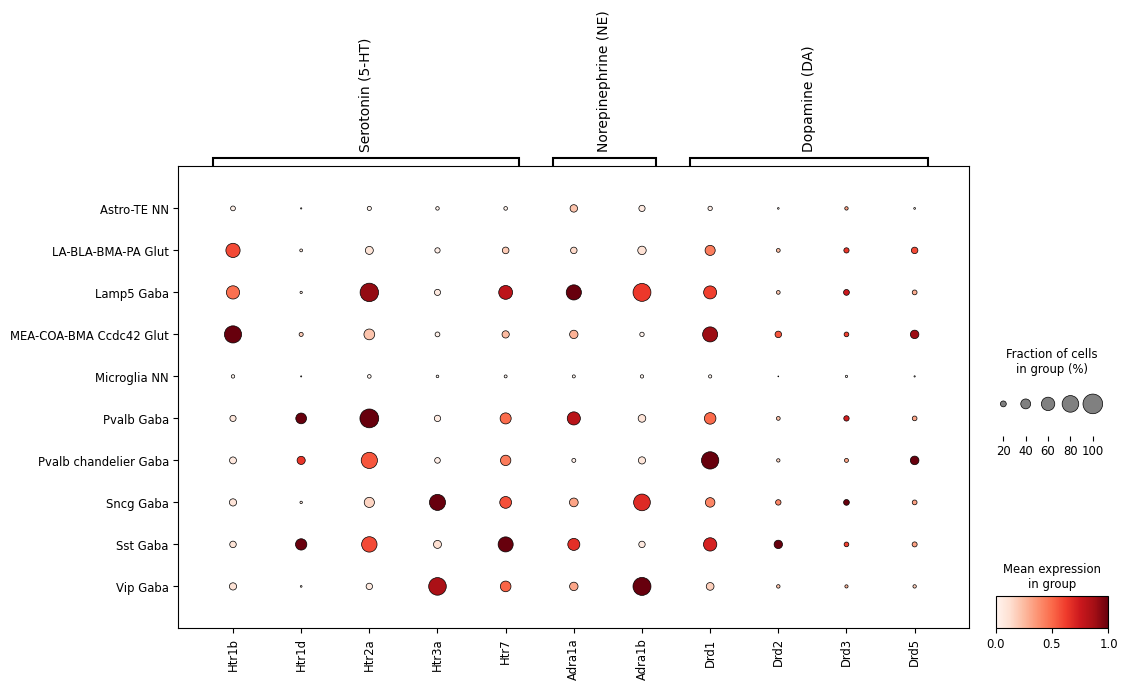

Saved: dotplot_BLA_MERFISH_receptors_by_subclass.png


In [9]:
# Gene groups
receptor_groups = {
    'Serotonin (5-HT)': [g for g in serotonin_receptors if g in receptor_genes],
    'Norepinephrine (NE)': [g for g in norepinephrine_receptors if g in receptor_genes],
    'Dopamine (DA)': [g for g in dopamine_receptors if g in receptor_genes],
}

# Subclass dot plot
dp = sc.pl.dotplot(
    adata_bla,
    var_names=receptor_groups,
    groupby='subclass_short',
    standard_scale='var',
    cmap='Reds',
    figsize=(12, max(6, n_subclasses * 0.5)),
    show=False,
    return_fig=True
)
dp.style(dot_edge_color='black', dot_edge_lw=0.5)
dp.savefig('dotplot_BLA_MERFISH_receptors_by_subclass.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: dotplot_BLA_MERFISH_receptors_by_subclass.png")

## 8. Finer View: Grouped by Supertype

Supertype-level dot plot for BLA cell types with at least 40 cells.

Supertypes with >= 40 cells: 21


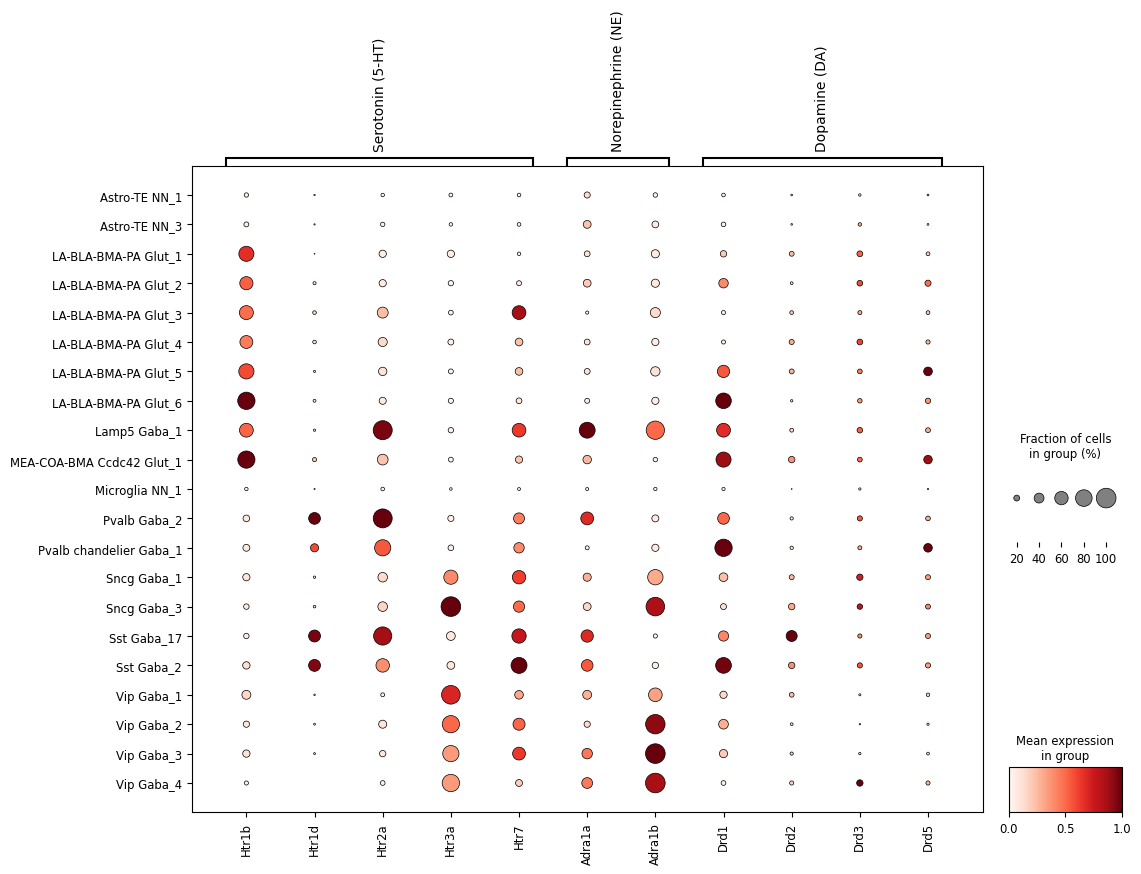

Saved: dotplot_BLA_MERFISH_receptors_by_supertype.png


In [10]:
# Filter to supertypes with sufficient cells
min_cells = 40
supertype_counts = adata_bla.obs.groupby('supertype', observed=True).size()
valid_supertypes = supertype_counts[supertype_counts >= min_cells].index.tolist()

adata_st = adata_bla[adata_bla.obs['supertype'].isin(valid_supertypes)].copy()
adata_st.obs['supertype_short'] = pd.Categorical(adata_st.obs['supertype_short'])

n_st = len(valid_supertypes)
print(f"Supertypes with >= {min_cells} cells: {n_st}")

dp2 = sc.pl.dotplot(
    adata_st,
    var_names=receptor_groups,
    groupby='supertype_short',
    standard_scale='var',
    cmap='Reds',
    figsize=(12, max(6, n_st * 0.4)),
    show=False,
    return_fig=True
)
dp2.style(dot_edge_color='black', dot_edge_lw=0.5)
dp2.savefig('dotplot_BLA_MERFISH_receptors_by_supertype.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: dotplot_BLA_MERFISH_receptors_by_supertype.png")

## 9. Anterior / Posterior / Ventral Breakdown

Split each cell type by BLA substructure (BLAa, BLAp, BLAv) to reveal
any spatial gradients in receptor expression along the anterior-posterior axis.

Cell type × substructure groups (>= 30 cells): 26
  LA-BLA-BMA-PA Glut (BLAa): 2,207
  LA-BLA-BMA-PA Glut (BLAp): 1,920
  LA-BLA-BMA-PA Glut (BLAv): 357
  MEA-COA-BMA Ccdc42 Glut (BLAa): 318
  Lamp5 Gaba (BLAa): 56
  Lamp5 Gaba (BLAp): 38
  Lamp5 Gaba (BLAv): 43
  Pvalb Gaba (BLAa): 97
  Pvalb Gaba (BLAp): 151
  Pvalb Gaba (BLAv): 74
  Pvalb chandelier Gaba (BLAa): 42
  Sncg Gaba (BLAa): 64
  Sncg Gaba (BLAp): 49
  Sncg Gaba (BLAv): 31
  Sst Gaba (BLAa): 82
  Sst Gaba (BLAp): 183
  Sst Gaba (BLAv): 104
  Vip Gaba (BLAa): 97
  Vip Gaba (BLAp): 117
  Vip Gaba (BLAv): 66
  Astro-TE NN (BLAa): 728
  Astro-TE NN (BLAp): 722
  Astro-TE NN (BLAv): 382
  Microglia NN (BLAa): 119
  Microglia NN (BLAp): 81
  Microglia NN (BLAv): 65


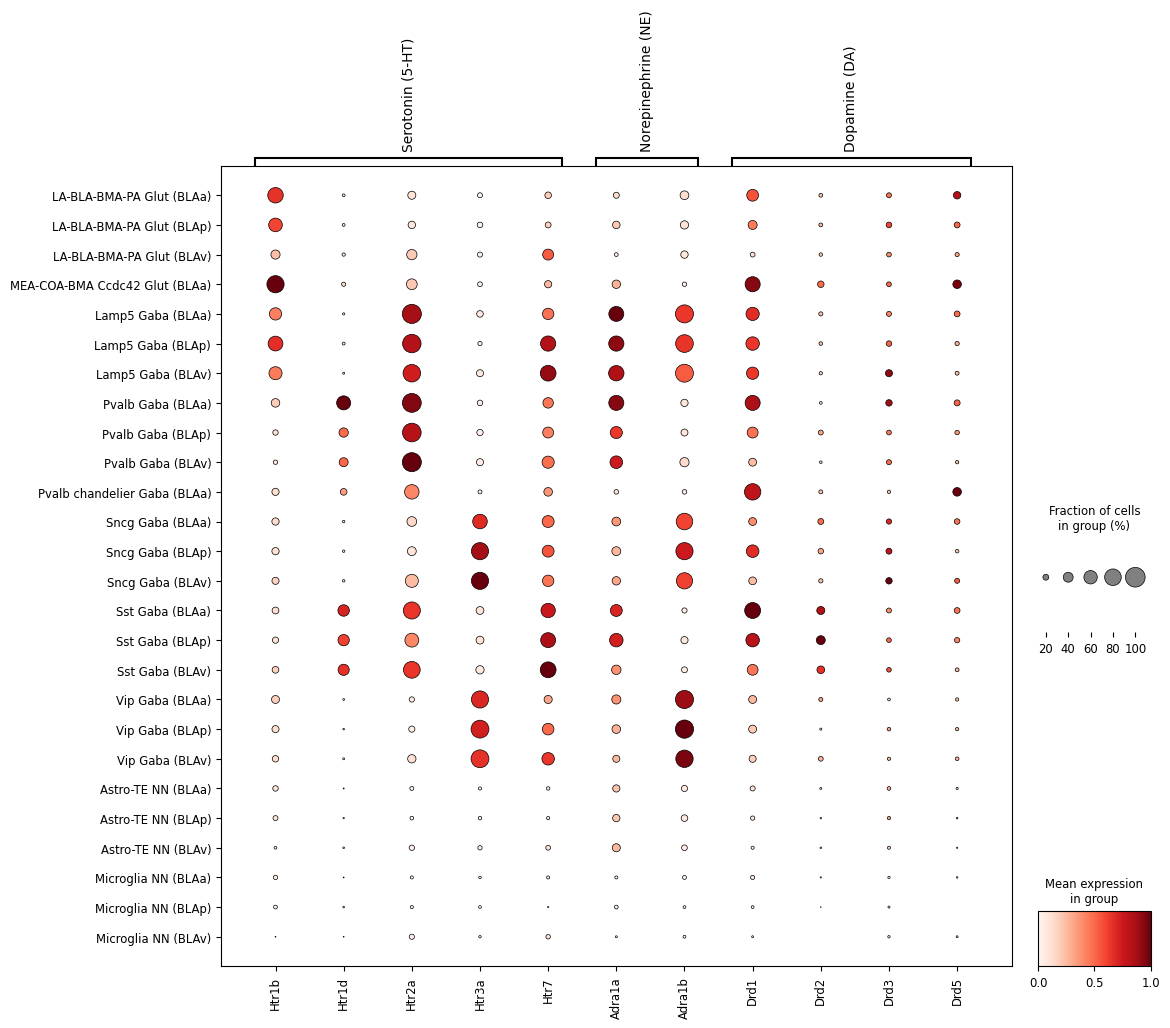

Saved: dotplot_BLA_MERFISH_receptors_by_substructure.png


In [11]:
# Create combined label: subclass + substructure
adata_bla.obs['cell_type_region'] = (
    adata_bla.obs['subclass_short'].astype(str) + ' (' +
    adata_bla.obs['parcellation_substructure'].astype(str) + ')'
)

# Filter to groups with >= 30 cells
group_counts = adata_bla.obs.groupby('cell_type_region', observed=True).size()
valid_groups = group_counts[group_counts >= 30].index.tolist()
adata_apv = adata_bla[adata_bla.obs['cell_type_region'].isin(valid_groups)].copy()

# Sort: excitatory first, then interneurons, then glia; within each by A/P/V
def sort_key(name):
    parts = name.rsplit(' (', 1)
    sc = parts[0]
    sub = parts[1].rstrip(')') if len(parts) > 1 else ''
    if any(kw in sc for kw in ['Glut', 'Ccdc42']):
        cat = 0
    elif 'NN' in sc:
        cat = 2
    else:
        cat = 1
    sub_order = {'BLAa': 0, 'BLAp': 1, 'BLAv': 2}
    return (cat, sc, sub_order.get(sub, 9))

sorted_groups = sorted(valid_groups, key=sort_key)
adata_apv.obs['cell_type_region'] = pd.Categorical(
    adata_apv.obs['cell_type_region'], categories=sorted_groups, ordered=True
)

n_groups = len(sorted_groups)
print(f"Cell type × substructure groups (>= 30 cells): {n_groups}")
for g in sorted_groups:
    print(f"  {g}: {group_counts[g]:,}")

dp3 = sc.pl.dotplot(
    adata_apv,
    var_names=receptor_groups,
    groupby='cell_type_region',
    standard_scale='var',
    cmap='Reds',
    figsize=(12, max(8, n_groups * 0.4)),
    show=False,
    return_fig=True
)
dp3.style(dot_edge_color='black', dot_edge_lw=0.5)
dp3.savefig('dotplot_BLA_MERFISH_receptors_by_substructure.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: dotplot_BLA_MERFISH_receptors_by_substructure.png")

## 10. Summary Statistics

In [12]:
expr_df = pd.DataFrame(
    adata_bla.X,
    index=adata_bla.obs.index,
    columns=adata_bla.var.index
)
expr_df['subclass'] = adata_bla.obs['subclass_short'].values

mean_expr = expr_df.groupby('subclass', observed=True)[receptor_genes].mean()
frac_expr = expr_df.groupby('subclass', observed=True)[receptor_genes].apply(
    lambda x: (x > 0).mean()
)

print("=" * 70)
print("Mean Expression (log2) by BLA Subclass — MERFISH")
print("=" * 70)
display(mean_expr.round(2))

print("\n" + "=" * 70)
print("Fraction of Expressing Cells by BLA Subclass — MERFISH")
print("=" * 70)
display(frac_expr.round(3))

Mean Expression (log2) by BLA Subclass — MERFISH


,Htr1b,Htr1d,Htr2a,Htr3a,Htr7,Adra1a,Adra1b,Drd1,Drd2,Drd3,Drd5
subclass,,,,,,,,,,,
Astro-TE NN,0.14,0.02,0.12,0.10,0.09,0.27,0.22,0.13,0.03,0.10,0.03
LA-BLA-BMA-PA Glut,1.05,0.06,0.32,0.17,0.25,0.21,0.32,0.61,0.12,0.14,0.23
Lamp5 Gaba,0.89,0.05,2.13,0.26,0.77,0.99,1.41,0.82,0.11,0.16,0.13
MEA-COA-BMA Ccdc42 Glut,1.75,0.12,0.59,0.15,0.29,0.33,0.13,1.16,0.25,0.14,0.33
Microglia NN,0.09,0.02,0.09,0.06,0.07,0.07,0.08,0.08,0.01,0.05,0.02
Pvalb Gaba,0.22,0.54,2.33,0.21,0.50,0.81,0.30,0.68,0.11,0.16,0.13
Pvalb chandelier Gaba,0.21,0.35,1.33,0.17,0.46,0.10,0.28,1.29,0.08,0.09,0.37
Sncg Gaba,0.26,0.06,0.47,2.87,0.57,0.37,1.51,0.59,0.19,0.20,0.14
Sst Gaba,0.25,0.53,1.40,0.41,0.94,0.68,0.23,0.95,0.44,0.14,0.14



Fraction of Expressing Cells by BLA Subclass — MERFISH


,Htr1b,Htr1d,Htr2a,Htr3a,Htr7,Adra1a,Adra1b,Drd1,Drd2,Drd3,Drd5
subclass,,,,,,,,,,,
Astro-TE NN,0.151,0.027,0.126,0.102,0.106,0.275,0.217,0.135,0.038,0.097,0.041
LA-BLA-BMA-PA Glut,0.650,0.076,0.301,0.174,0.236,0.230,0.324,0.413,0.112,0.172,0.229
Lamp5 Gaba,0.591,0.058,0.920,0.212,0.628,0.708,0.883,0.577,0.109,0.197,0.153
MEA-COA-BMA Ccdc42 Glut,0.835,0.125,0.449,0.153,0.265,0.321,0.137,0.701,0.231,0.150,0.327
Microglia NN,0.098,0.023,0.106,0.068,0.079,0.083,0.094,0.091,0.015,0.057,0.026
Pvalb Gaba,0.214,0.447,0.944,0.220,0.466,0.584,0.283,0.494,0.112,0.177,0.149
Pvalb chandelier Gaba,0.250,0.310,0.774,0.190,0.429,0.119,0.262,0.845,0.095,0.119,0.333
Sncg Gaba,0.264,0.062,0.417,0.764,0.507,0.340,0.806,0.382,0.181,0.194,0.153
Sst Gaba,0.230,0.480,0.724,0.301,0.702,0.520,0.225,0.596,0.322,0.149,0.163
